# NN implemented from scratch


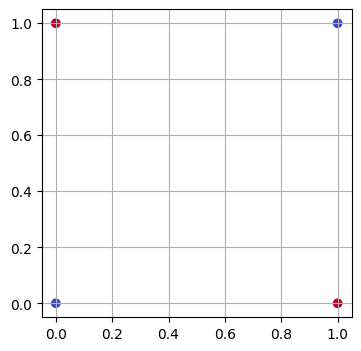

In [4]:
# input: 2 features 
# output: classification
# hidden: 1 layer, 2 neurons. 
# iterations: 200
# record training loss every 20 iterations
# sigmoid for hidden, relu for output
# cross entropy loss as training objective
# heat map from 0.5 to 0.5. 

import matplotlib.pyplot as plt
import numpy as np

data_xs = np.array([[0,0],[0,1],[1,0],[1,1]])
data_ys = np.array([[0,1,1,0]])

fig,ax = plt.subplots(1,1,figsize=(4.,4.))
ax.scatter(data_xs[:,0],data_xs[:,1],c = data_ys.ravel(),cmap='coolwarm')
ax.grid(True)
plt.show()

In [5]:
class Sigmoid:
    def value(self, x):
        return 1 / (1 + np.exp(-x))

    def derivative(self, x):
        return np.multiply(self.value(x), (1 - self.value(x)))

class ReLU:
    def value(self, x):
        return np.maximum(0, x)
    
    def derivative(self, x):
        return np.where(x > 0, 1, 0)
    
class CrossEntropyLoss:
    def __init__(self) -> None:
        self.epsilon = 0.0001

    def value(self, y_hat, y):
        # use this to stop perfect 0 or 1s preds
        y_hat = np.clip(y_hat, self.epsilon, 1 - self.epsilon)
        return - 1 / len(y) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def derivative(self, y_hat, y):
        y_hat = np.clip(y_hat, self.epsilon, 1 - self.epsilon)
        return np.divide(y_hat - y, y_hat * (1 - y_hat))

In [37]:
class MLP:
    def __init__(self, n_features, layer_sizes, activations, loss_fn, lr=0.01):
        sizes = [n_features] + layer_sizes
        self.n_layers = len(layer_sizes)
        self.activations = activations
        self.loss_fn = loss_fn
        self.lr = lr
        self.W = []

        # init rand weights
        for i in range(self.n_layers):
            weights = np.random.randn(sizes[i], sizes[i+1])
            biases = np.zeros((1, sizes[i+1]))
            weights = np.concatenate([biases, weights], axis=0)
            self.W.append(weights)


    def forward_pass(self, X):
        a_vals = []
        z_vals = []

        temp = X
        for i in range(self.n_layers):
            # augment data with bias
            biases = np.ones((temp.shape[0], 1))
            temp = np.concatenate([biases, temp], axis=1)
            temp = temp @ self.W[i]
            a_vals.append(temp)

            # activation fn 
            temp = self.activations[i].value(temp)
            z_vals.append(temp)

        return a_vals, z_vals
    
    def backward_pass(self, a_vals, loss_deri):
        deltas = []
        base_delta = loss_deri * self.activations[-1].derivative(a_vals[-1])
        deltas.append(base_delta)

        for i in range(self.n_layers - 1)[::-1]:  
            delta = np.dot(deltas[-1], self.W[i+1][1:].T) * self.activations[i].derivative(a_vals[i])
            deltas.append(delta)
        
        return deltas[::-1]

    def update_weights(self, X, Z_vals, deltas):
        update_layers = [X] + Z_vals[:-1]
        for i in range(self.n_layers)[::-1]:
            # add back bias 
            bias_update_layer = np.concatenate([np.ones((update_layers[i].shape[0], 1)), update_layers[i]], axis=1)
            
            # weight update
            neuron_update = np.dot(bias_update_layer.T, deltas[i])
            self.W[i] = self.W[i] - self.lr * neuron_update

        return self.W

    
    def train(self, X: np.ndarray, y: np.ndarray, epochs: int):
        res = []
        for i in range(epochs):
            a_vals, z_vals = self.forward_pass(X)
            y_hat = z_vals[-1]
            loss = self.loss_fn.value(y_hat, y)

            # print(loss)
            if i % 20 == 0:
                res.append({"loss": loss, "weights": self.W.copy()})

            dLdyhat = self.loss_fn.derivative(y_hat, y)
            deltas = self.backward_pass(a_vals, dLdyhat)
            self.W = self.update_weights(X, z_vals, deltas)

        return res
    
    def predict(self, X, weights=None):
        if weights == None:
            weights = self.W

        _, z_vals = self.forward_pass(X)       # Make predictions for these examples
        return z_vals[-1]
    
    def get_neuron_activation(self, X, weights):
        temp = X
        biases = np.ones((temp.shape[0], 1))
        temp = np.concatenate([biases, temp], axis=1)
        temp = temp @ weights[0]
        # activation fn 
        temp = self.activations[0].value(temp)

        return temp



mlp = MLP(data_xs.shape[1], layer_sizes=[2, 1], activations=[ReLU(), Sigmoid()], loss_fn=CrossEntropyLoss(), lr=0.2)

res = mlp.train(data_xs, data_ys.reshape(-1, 1), 200)
print(res[-1]['loss'])

mlp.get_neuron_activation(data_xs, res[-1]['weights'])


0.022818859084651123


array([[0.        , 0.        ],
       [0.01510649, 2.33980445],
       [0.0127863 , 2.3382443 ],
       [3.16407344, 4.6996706 ]])

In [38]:
# viewing improvements and boundaries over time
x = np.linspace(-0.5, 1.5, 100)  # Linearly spaced values from 0 to 5 (row-wise)
y = np.linspace(-0.5, 1.5, 100)  # Linearly spaced values from 0 to 5 (row-wise)
points = np.array([[xi, yi] for xi in x for yi in y])

preds = mlp.predict(points, res[0]['weights'])

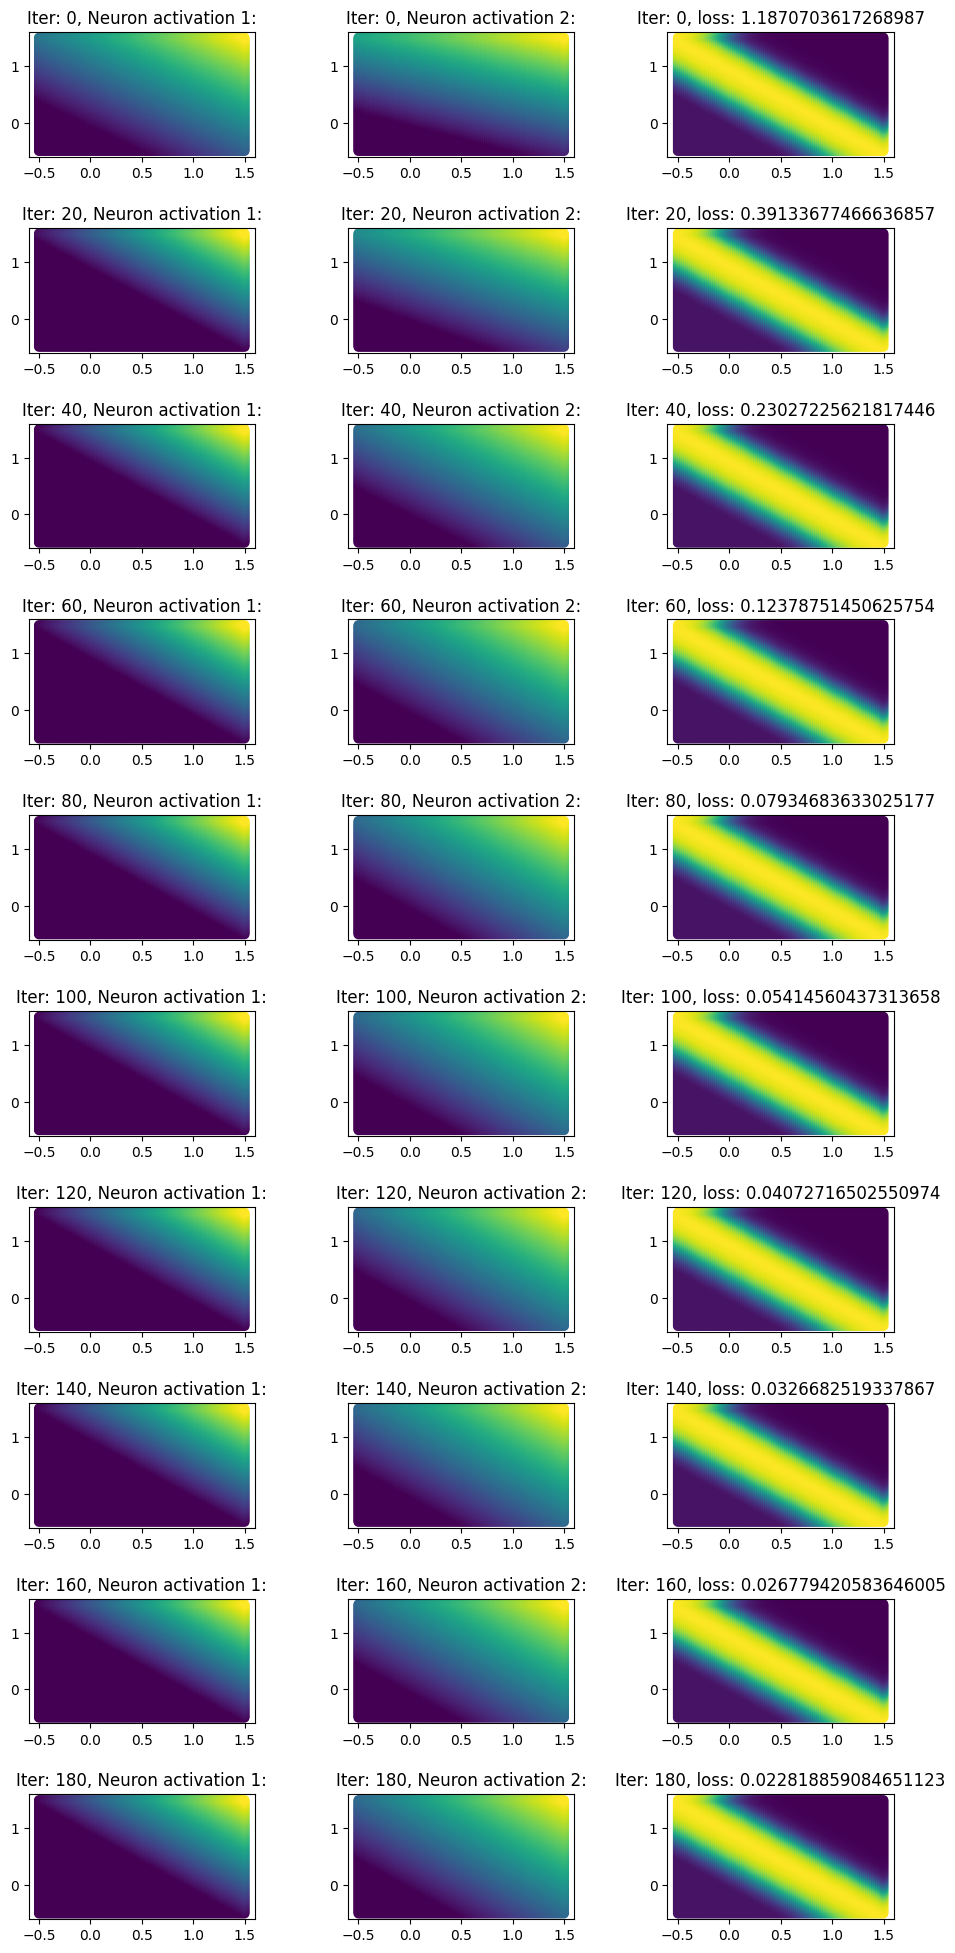

In [39]:
import matplotlib.pyplot as plt
n_subplots = 30
rows = 10 
cols = 3 

fig, axes = plt.subplots(rows, cols, figsize=(10, 20))
fig.tight_layout(pad=3.0)


x = np.linspace(-0.5, 1.5, 100)
y = np.linspace(-0.5, 1.5, 100)
points = np.array([[xi, yi] for xi in x for yi in y])


# Customize each column
for col in range(10):
    preds = mlp.predict(points, res[col]['weights'])
    neuron_activations = mlp.get_neuron_activation(points, res[col]['weights'])
    
    ax = axes[col, 0]
    ax.set_title(f"Iter: {col * 20}, Neuron activation 1:")
    ax.scatter(points[:, 0], points[:, 1], c=neuron_activations[:, 0])
    
    ax = axes[col, 1]
    ax.set_title(f"Iter: {col * 20}, Neuron activation 2:")
    ax.scatter(points[:, 0], points[:, 1], c=neuron_activations[:, 1])
    
    ax = axes[col, 2]
    ax.set_title(f"Iter: {col * 20}, loss: {res[col]['loss']}")
    ax.scatter(points[:, 0], points[:, 1], c=preds)

plt.show()
